# Golden spiral test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points on the sphere laid out as a golden spiral (a.k.a. a Fibonacci spiral) as an example and impose a "survey footprint" that $|\cos\theta|<1/2$.

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt
#
sys.path.append('../csht')
from sht import DirectSHT

In [2]:
# Set up an sht instance.  We will set
# Nx to be quite large, so that we are
# confident in our interpolation.
Nl   = 512
Nx   = 2048+1
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)

In [3]:
# Code to lay down N points in a golden spiral (a.k.a. Fibonacci spiral).
def golden_spiral(Npnt):
    """Returns (theta,phi) for Npnt points in a golden spiral."""
    grat  = 0.5*(1 + np.sqrt(5.)) # Golden ratio.
    kk    = np.arange(Npnt,dtype='float64')
    phi   = 2*np.pi*kk / grat
    theta = np.arccos(1 - (2*kk+1)/Npnt)
    return( (theta,phi) )

In [4]:
# Generate points and cut to the "observed region".
npnt = 131072
thetas,phis = golden_spiral(npnt)
ww   = np.nonzero( np.abs(np.cos(thetas))<0.5 )[0]
thetas,phis = thetas[ww],phis[ww]
wts  = np.ones_like(thetas)

## Harmonic analysis.

Let's compute the $a_{\ell m}$ by direct summation, compute the pseudo-power spectrum and look at the sources on a map.

On a single thread this is kind of slow, but not unmanageable.

In [5]:
halm = sht(thetas,phis,wts)
hcl  = hp.alm2cl(halm)

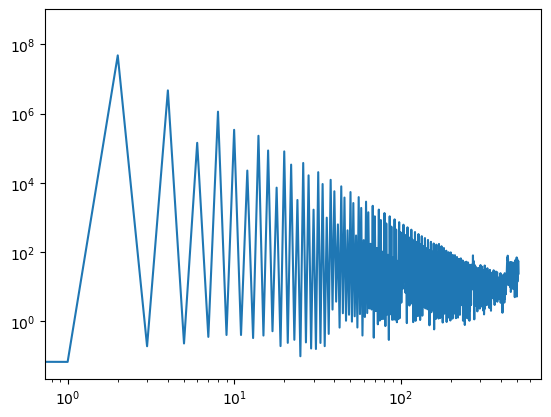

In [6]:
# Let's just plot them.
plt.loglog(hcl)

0.0 180.0 -180.0 180.0


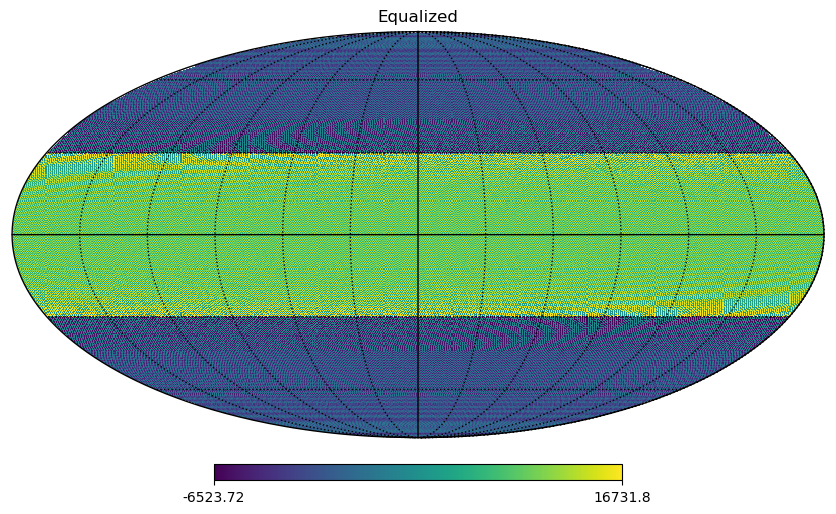

In [7]:
nside = 1024
#
hp.mollview(hp.alm2map(halm,nside),norm='hist',title='Equalized')
hp.graticule()
plt.show()

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [8]:
def make_map(thetas,phis,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

0.0 180.0 -180.0 180.0


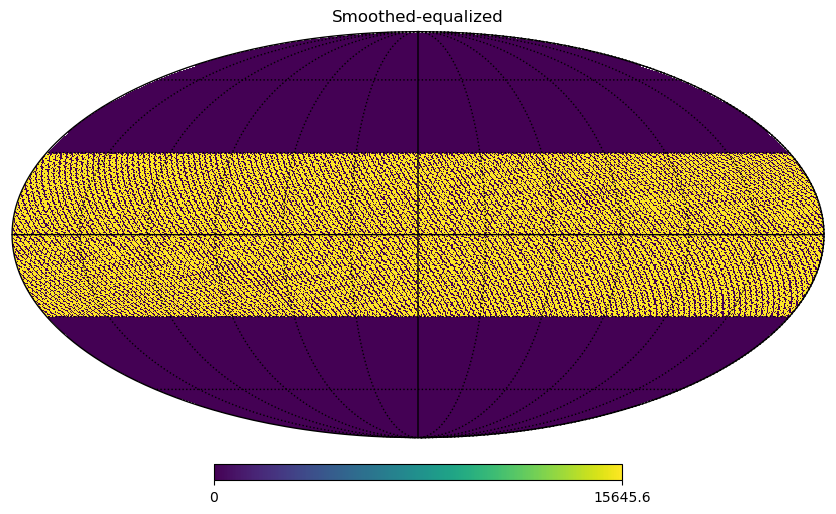

In [9]:
# Show an example at some nside.
dmap = make_map(thetas,phis,128)
hp.mollview(dmap,norm='hist',title='Smoothed-equalized')
hp.graticule()
plt.show()

Now compare the power spectra as a function of the map Nside.

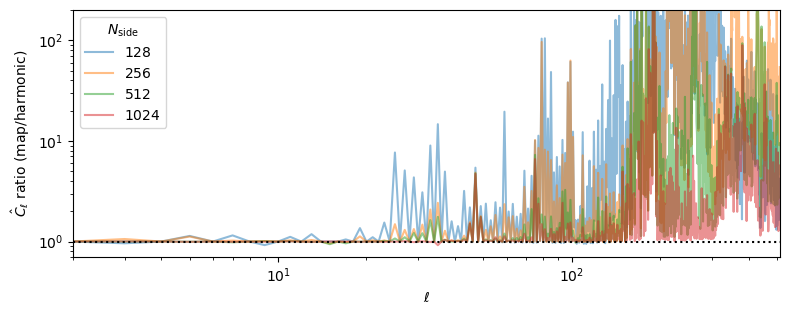

In [10]:
fig,ax = plt.subplots(1,1,figsize=(8,3.25))
#
icol= 0
for nside in [128,256,512,1024]:
    dmap = make_map(thetas,phis,nside)
    mcl  = hp.sphtfunc.anafast(dmap,alm=False,\
                               lmax=sht.Nell-1,pol=False)
    ratio= mcl/hcl
    ell  = np.arange(ratio.size) + 1e-8
    #
    ax.plot(ell,ratio,color='C'+str(icol),alpha=0.5,\
            label='${:4d}$'.format(nside))
    icol = (icol+1)%10
ax.axhline(1.0,ls=':',color='k')
ax.legend(title=r'$N_{\rm side}$')
ax.set_xlim(2.0,512)
ax.set_ylim(0.7,200)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$ ratio (map/harmonic)')
#
plt.tight_layout()

# The End